In [9]:
import pandas as pd
test_df=pd.read_csv('test_data.csv')
test_df

,id,patient,image_path,mask_path,diagnosis
0,29,TCGA_DU_7298_19910324,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7298_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7298_19...,0
1,7,TCGA_HT_7877_19980917,lgg-mri-segmentation/kaggle_3m\TCGA_HT_7877_19...,lgg-mri-segmentation/kaggle_3m\TCGA_HT_7877_19...,0
2,7,TCGA_FG_5964_20010511,lgg-mri-segmentation/kaggle_3m\TCGA_FG_5964_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_5964_20...,0
3,32,TCGA_FG_A4MU_20030903,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A4MU_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A4MU_20...,0
4,43,TCGA_DU_6400_19830518,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6400_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6400_19...,0
...,...,...,...,...,...
762,27,TCGA_DU_6407_19860514,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6407_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6407_19...,1
763,37,TCGA_DU_A5TR_19970726,lgg-mri-segmentation/kaggle_3m\TCGA_DU_A5TR_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_A5TR_19...,0
764,30,TCGA_FG_6690_20020226,lgg-mri-segmentation/kaggle_3m\TCGA_FG_6690_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_6690_20...,1
765,45,TCGA_DU_7008_19830723,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7008_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7008_19...,0


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
inference_transforms = A.Compose([
    A.Resize(224,224, p=1.0),
    ToTensorV2(),
])

In [11]:
from loader import MRISegmentationDataset
test_ds=MRISegmentationDataset(test_df,inference_transforms)

In [12]:
from torch.utils.data import DataLoader
test_loader=DataLoader(
    test_ds,batch_size=4,num_workers=4,shuffle=False  
)

In [13]:
def precision(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    total_predicted_pixels=y_pred.sum()
    return (intersection/total_predicted_pixels).mean()

def recall(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    total_true_pixels = y_true.sum()
    return (intersection / total_true_pixels).mean()

def dice_score(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    summation = (y_true + y_pred).sum()
    
    return ((2 * intersection) / (summation + eps))

def jaccard_index(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    union = (y_true + y_pred).sum() - intersection
    
    return (intersection / (union + eps))

In [14]:
import torch
from tqdm import tqdm
def compute(model,loader,device):
    metrics = {
    'accuracy'      : [],
    'precision'     : [],
    'recall'        : [],
    'dice_score'    : [],
    'IoU' : []
    }
    
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()
            for true_mask, pred_mask in zip(y, predicted_class):
                acc = ((true_mask == pred_mask).sum() / torch.numel(true_mask)).cpu().item()
                prec = precision(true_mask, pred_mask).cpu().item()
                rec = recall(true_mask, pred_mask).cpu().item()
                dice = dice_score(true_mask, pred_mask).cpu().item()
                iou = jaccard_index(true_mask, pred_mask).cpu().item()
                
                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['dice_score'].append(dice)
                metrics['IoU'].append(iou)
    return metrics

In [15]:
from unet_model import build_unet
model=build_unet()
model.load_state_dict(torch.load('Unet_Model_epoch_99.pth'))
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=model.to(device)

In [16]:
from train import predict
unet_test_masks=predict(model,test_loader,device)

100%|██████████| 192/192 [00:46<00:00,  4.12it/s]


In [17]:
metrics=compute(model,test_loader,device)

100%|██████████| 192/192 [00:39<00:00,  4.80it/s]


In [18]:
unet_test_df = test_df.copy()

unet_test_df = pd.concat(
    (unet_test_df, pd.DataFrame(metrics)), 
    axis=1
)

unet_test_df['model_diagnosis'] = [
    int(mask.max()) for mask in unet_test_masks
]

unet_test_df

,id,patient,image_path,mask_path,diagnosis,accuracy,precision,recall,dice_score,IoU,model_diagnosis
0,29,TCGA_DU_7298_19910324,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7298_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7298_19...,0,1.000000,NaN,NaN,0.000000,0.000000,0
1,7,TCGA_HT_7877_19980917,lgg-mri-segmentation/kaggle_3m\TCGA_HT_7877_19...,lgg-mri-segmentation/kaggle_3m\TCGA_HT_7877_19...,0,1.000000,NaN,NaN,0.000000,0.000000,0
2,7,TCGA_FG_5964_20010511,lgg-mri-segmentation/kaggle_3m\TCGA_FG_5964_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_5964_20...,0,1.000000,NaN,NaN,0.000000,0.000000,0
3,32,TCGA_FG_A4MU_20030903,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A4MU_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A4MU_20...,0,1.000000,NaN,NaN,0.000000,0.000000,0
4,43,TCGA_DU_6400_19830518,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6400_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6400_19...,0,1.000000,NaN,NaN,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
762,27,TCGA_DU_6407_19860514,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6407_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_6407_19...,1,0.997449,0.976783,0.969418,0.973087,0.947584,1
763,37,TCGA_DU_A5TR_19970726,lgg-mri-segmentation/kaggle_3m\TCGA_DU_A5TR_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_A5TR_19...,0,1.000000,NaN,NaN,0.000000,0.000000,0
764,30,TCGA_FG_6690_20020226,lgg-mri-segmentation/kaggle_3m\TCGA_FG_6690_20...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_6690_20...,1,0.996074,0.814238,0.960630,0.881397,0.787944,1
765,45,TCGA_DU_7008_19830723,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7008_19...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_7008_19...,0,1.000000,NaN,NaN,0.000000,0.000000,0


In [21]:
non_diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 0
    ][metrics.keys()].mean()
)

diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ][metrics.keys()].mean()
)

segmetation_metrics = pd.DataFrame({
    'non_diagnosed_metrics': non_diagnosed_metrics,
    'diagnosed_metrics': diagnosed_metrics, }).T

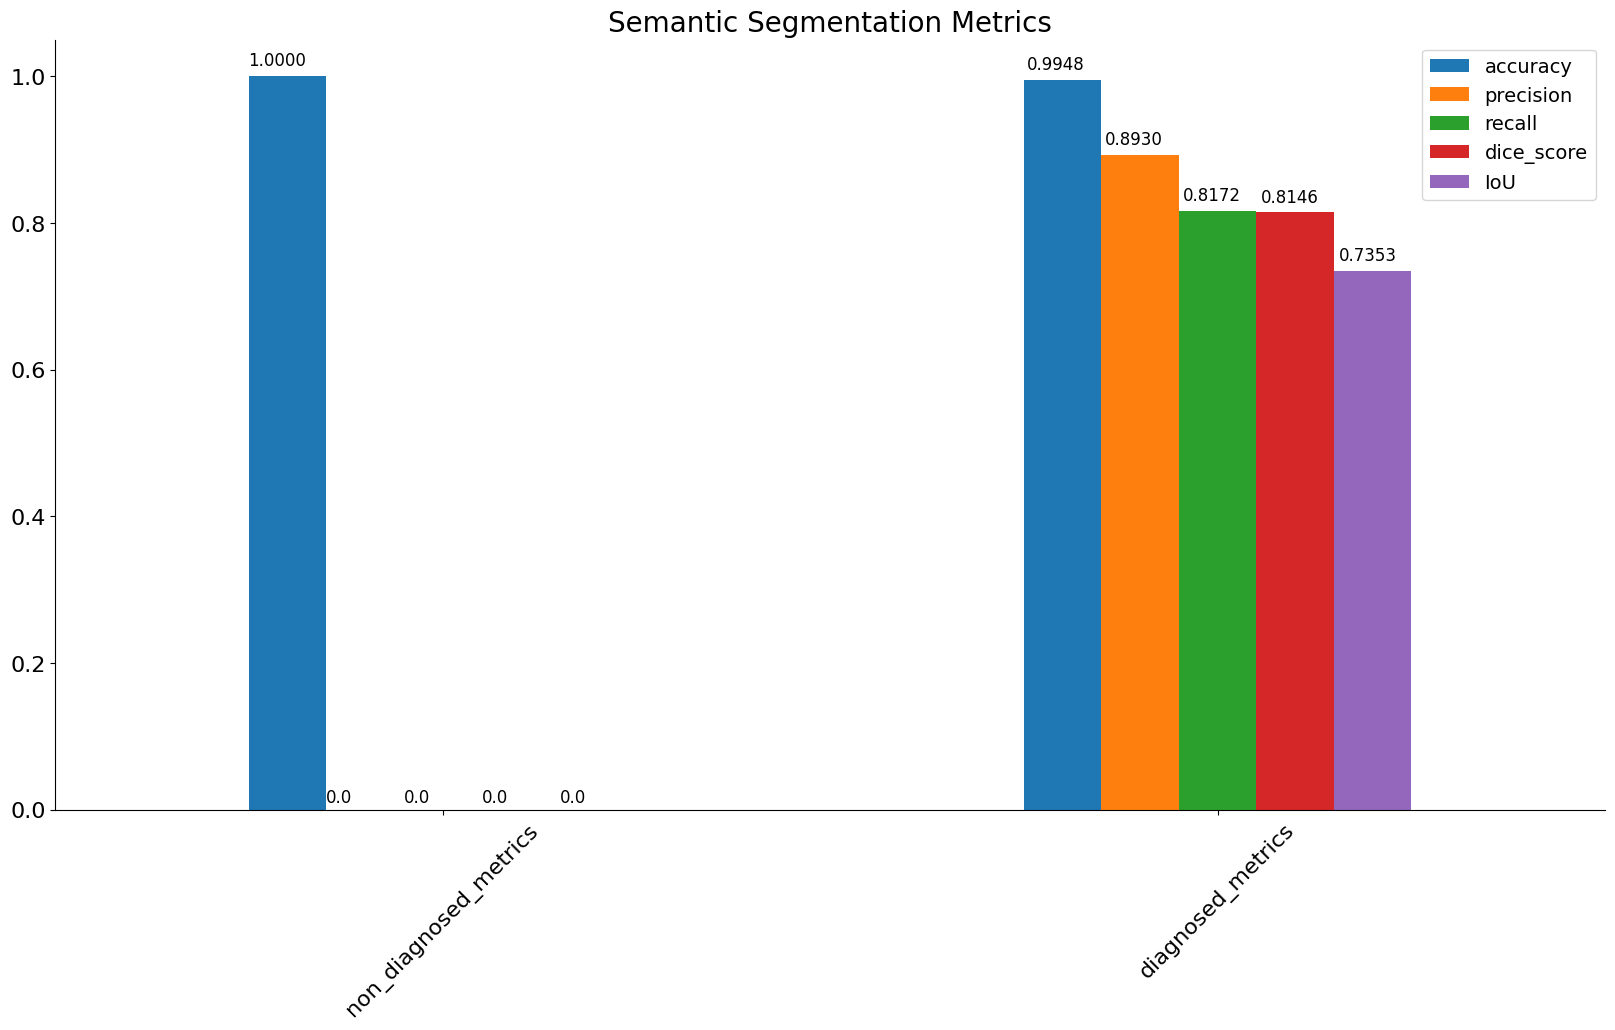

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = segmetation_metrics.plot(
    kind="bar", rot=0,
    figsize=(20, 10)
)

ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)

for p in ax.patches:
    bar_value = p.get_height()
    text = '0.0' if bar_value==0 else f'{bar_value:.4f}'
    ax.annotate(
        text, 
        (p.get_x() * 1.005, p.get_height() * 1.005 + 0.01), 
        fontsize=12
    )

ax.tick_params( axis='both', which='major', 
    labelsize=16
)

ax.tick_params(
    axis='x', which='major', 
    labelsize=16, rotation=45
)

plt.title('Semantic Segmentation Metrics', fontsize=20);
sns.despine()

In [23]:
labels = unet_test_df['diagnosis'].to_numpy()
predictions = unet_test_df['model_diagnosis'].to_numpy()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions, target_names=['NORMAL', 'TUMOR']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       499
       TUMOR       0.98      0.95      0.96       268

    accuracy                           0.98       767
   macro avg       0.98      0.97      0.97       767
weighted avg       0.98      0.98      0.98       767

